# Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torchvision import datasets
import torchvision.models as models
from warnings import filterwarnings
filterwarnings('ignore')


# Data Exploration

In [ ]:
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/BrainTumorClsfn/Training')
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/BrainTumorClsfn/Testing')

In [ ]:
train_data.classes, test_data.classes

(['glioma', 'meningioma', 'notumor', 'pituitary'],
 ['glioma', 'meningioma', 'notumor', 'pituitary'])

In [ ]:
train_data.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
test_data.class_to_idx

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
import os
from collections import Counter

class_names = train_data.classes
print("Classes:", class_names)

train_counts = Counter([label for _, label in train_data.samples])
test_counts = Counter([label for _, label in test_data.samples])

print("Training Data Distribution:", {class_names[k]: v for k, v in train_counts.items()})
print("Testing Data Distribution:", {class_names[k]: v for k, v in test_counts.items()})


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training Data Distribution: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing Data Distribution: {'glioma': 301, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [ ]:
train_data[0]

(<PIL.Image.Image image mode=RGB size=512x512>, 0)

(512, 512) 0
AxesImage(shape=(512, 512, 3))


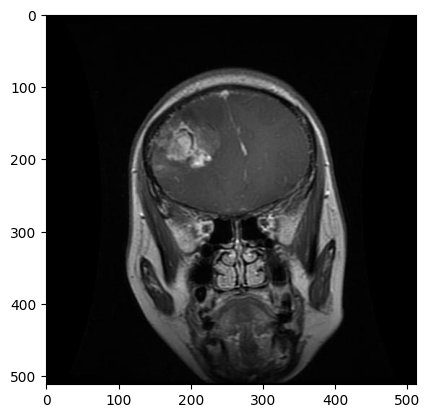

In [ ]:
image, label = train_data[0]
print(image.size, label)
print(plt.imshow(image))

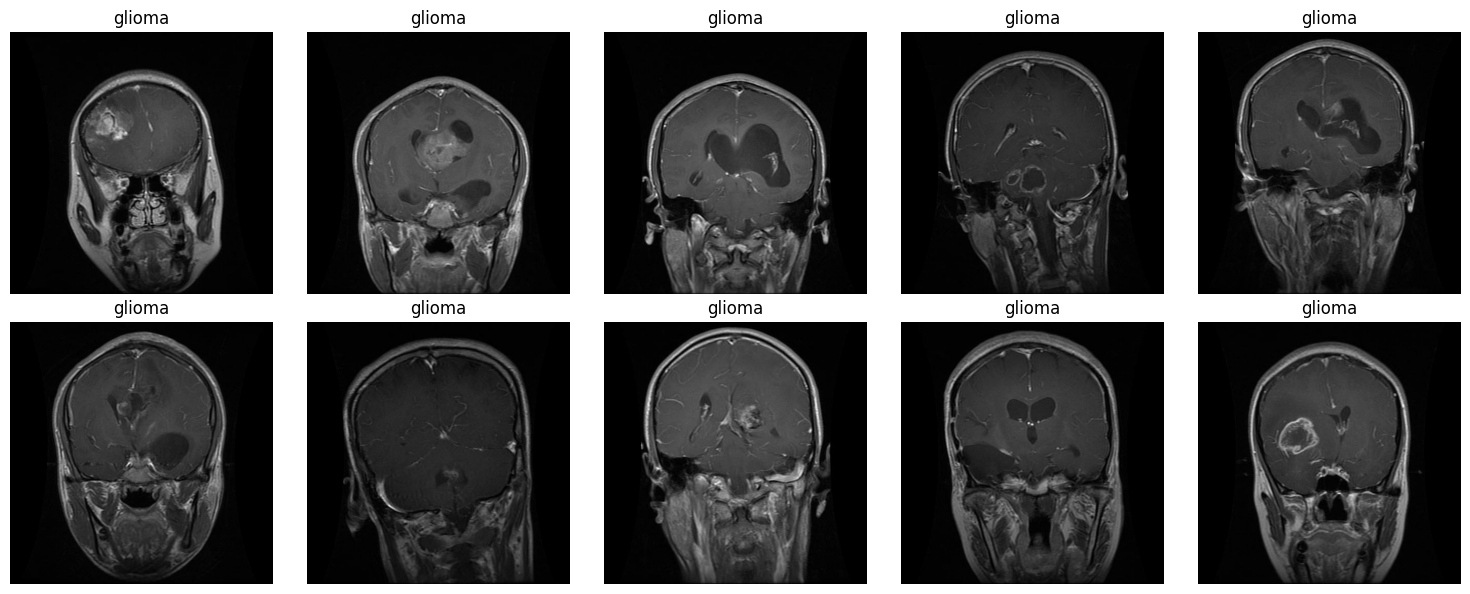

In [ ]:
class_names = train_data.classes

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    image, label = train_data[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis("off")

plt.tight_layout()
plt.show()


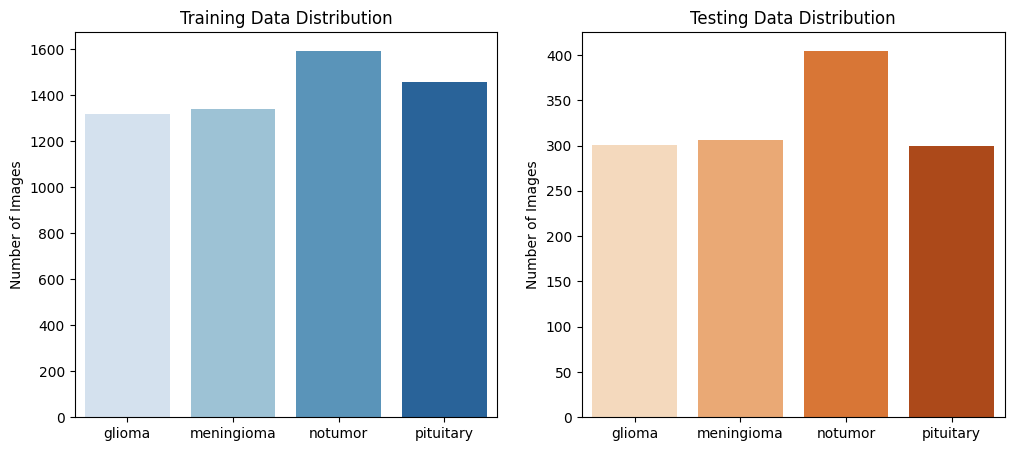

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

train_counts = [1321, 1339, 1595, 1457]
test_counts = [301, 306, 405, 300]
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=labels, y=train_counts, ax=ax[0], palette="Blues")
ax[0].set_title("Training Data Distribution")
ax[0].set_ylabel("Number of Images")

sns.barplot(x=labels, y=test_counts, ax=ax[1], palette="Oranges")
ax[1].set_title("Testing Data Distribution")
ax[1].set_ylabel("Number of Images")

plt.show()

In [ ]:
# class_names = train_data.classes
# fig, axes = plt.subplots(len(class_names), 4, figsize=(10, 8))
# for class_idx, class_name in enumerate(class_names):
#   count = 0
#   for data in train_data:
#     img, label = data
#     if label == class_idx and count < 4:
#       ax = axes[class_idx, count]
#       ax.imshow(img)
#       ax.set_title(class_name)
#       ax.axis("off")
#       if count == 0:
#         ax.set_ylabel(class_name, fontsize=12, fontweight="bold")
#       count += 1
#       if count == 4:
#         break
# plt.tight_layout()
# plt.show()



# Data Preprocessing

In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
train_dir = "/content/drive/MyDrive/BrainTumorClsfn/Training"
test_dir = "/content/drive/MyDrive/BrainTumorClsfn/Testing"

train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

class_names = train_data.classes
print("Class Labels:", class_names)


Class Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


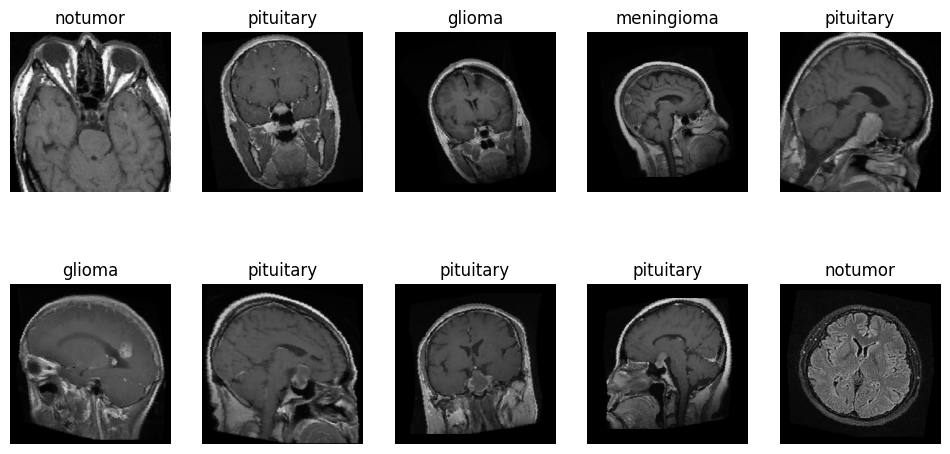

In [ ]:
def show_augmented_images(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))

    for i in range(10):
        img = images[i].permute(1, 2, 0).numpy()

        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(class_names[labels[i]])
        ax.axis("off")

    plt.show()

show_augmented_images(train_loader)

# Model Training - ResNet50

In [ ]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 4)

# Freeze all the layers
for param in resnet50.parameters():
    param.requires_grad = False

# Unfreeze the last Conv layer
for param in resnet50.layer4.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Define Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

optimizer = optim.Adam([
    {'params': resnet50.layer4.parameters(), 'lr': 1e-4},
    {'params': resnet50.fc.parameters(), 'lr': 1e-3}
])


print("ResNet50 model is ready for fine-tuning!")


ResNet50 model is ready for fine-tuning!


In [ ]:
# Hyperparameters
num_epochs = 10
batch_size = 16

# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': resnet50.layer4.parameters(), 'lr': 1e-4},
    {'params': resnet50.fc.parameters(), 'lr': 1e-3}
])

# Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for data in train_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    print("Training complete!")

# Train the model
train_model(resnet50, train_loader, criterion, optimizer, num_epochs)

# Save the trained model
torch.save(resnet50.state_dict(), "resnet50_brain_tumor.pth")
print("Model saved!")


Epoch [1/10], Loss: 0.4779, Accuracy: 83.75%
Epoch [2/10], Loss: 0.2449, Accuracy: 91.88%
Epoch [3/10], Loss: 0.1911, Accuracy: 93.52%
Epoch [4/10], Loss: 0.1452, Accuracy: 94.91%
Epoch [5/10], Loss: 0.1205, Accuracy: 95.59%
Epoch [6/10], Loss: 0.1180, Accuracy: 96.08%
Epoch [7/10], Loss: 0.0944, Accuracy: 96.95%
Epoch [8/10], Loss: 0.0876, Accuracy: 96.99%
Epoch [9/10], Loss: 0.0803, Accuracy: 97.41%
Epoch [10/10], Loss: 0.0663, Accuracy: 97.78%
Training complete!
Model saved!


Test Accuracy: 97.56%

Classification Report:
              precision    recall  f1-score   support

      Glioma       0.98      0.98      0.98       301
  Meningioma       0.94      0.95      0.95       306
    No Tumor       0.99      0.97      0.98       405
   Pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1312
   macro avg       0.97      0.98      0.98      1312
weighted avg       0.98      0.98      0.98      1312



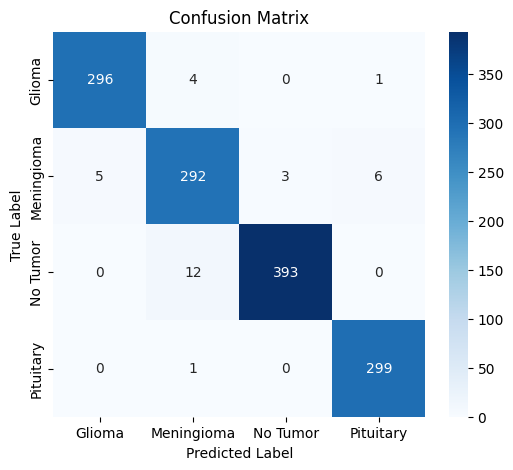

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
resnet50.load_state_dict(torch.load("resnet50_brain_tumor.pth"))
resnet50.eval()

# Function to evaluate model
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds

# Get predictions
true_labels, pred_labels = evaluate_model(resnet50, test_loader)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, fmt="d",
            xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'],
            cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import f1_score

all_preds = []
all_labels = []

resnet50.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute F1-score
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"**F1-Score on Testing Data: {f1:.4f}**")


🔹 **F1-Score on Testing Data: 0.9756**


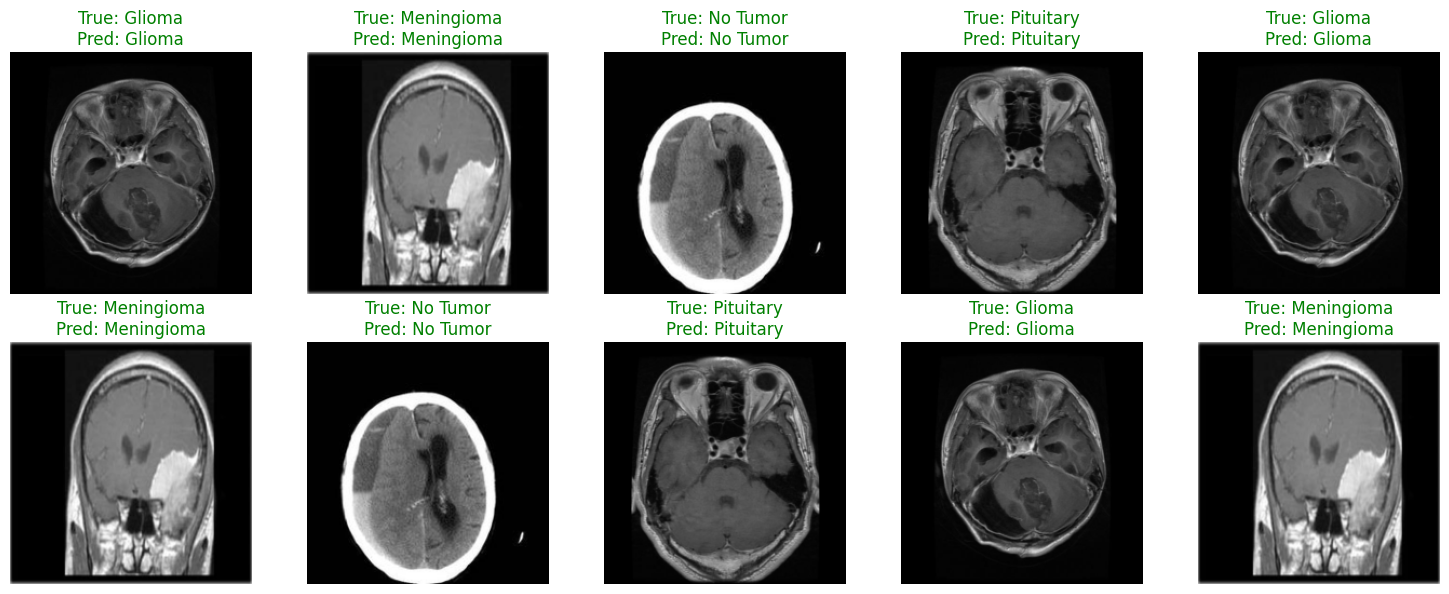

In [ ]:
import random

def show_diverse_predictions(model, test_loader):
    model.eval()
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Store images for each class
    selected_images = {cls: None for cls in range(4)}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Collect diverse images
            for i in range(len(labels)):
                label = labels[i].item()
                if selected_images[label] is None:
                    selected_images[label] = (images[i], labels[i], preds[i])
                if all(v is not None for v in selected_images.values()):  # Stop if all classes are found
                    break

    # Shuffle and pick 10 random images (ensuring diversity)
    diverse_samples = list(selected_images.values())
    random.shuffle(diverse_samples)

    for i in range(10):
        img, true_label, pred_label = diverse_samples[i % 4]  # Cycle through classes if < 10 images available
        img = img.cpu().permute(1, 2, 0).numpy()  # Convert tensor to image

        ax = axes[i // 5, i % 5]
        ax.imshow(img)
        ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                     color=("green" if true_label == pred_label else "red"))
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Show diverse predictions
show_diverse_predictions(resnet50, test_loader)


In [ ]:
model_path = "/content/drive/MyDrive/BrainTumorClsfn/brain_tumor_resnet50.pth"
torch.save(resnet50.state_dict(), model_path)
print("Model saved successfully!")


Model saved successfully!


In [ ]:
model_path = "/content/drive/MyDrive/BrainTumorClsfn/brain_tumor_resnet50.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(weights=None)
num_ftrs = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_ftrs, 4)
resnet50.load_state_dict(torch.load(model_path, map_location=device))
resnet50.to(device)
resnet50.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

resnet50.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)


              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       301
  meningioma       0.94      0.95      0.95       306
     notumor       0.99      0.97      0.98       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1312
   macro avg       0.97      0.98      0.98      1312
weighted avg       0.98      0.98      0.98      1312

[[296   4   0   1]
 [  5 292   3   6]
 [  0  12 393   0]
 [  0   1   0 299]]


In [ ]:
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total  # Accuracy percentage

# Compute Training Accuracy
train_accuracy = evaluate_accuracy(resnet50, train_loader, device)
print(f"Training Accuracy: {train_accuracy:.4f}")


Training Accuracy: 0.9839


In [ ]:
# Compute Test Accuracy
test_accuracy = evaluate_accuracy(resnet50, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9558


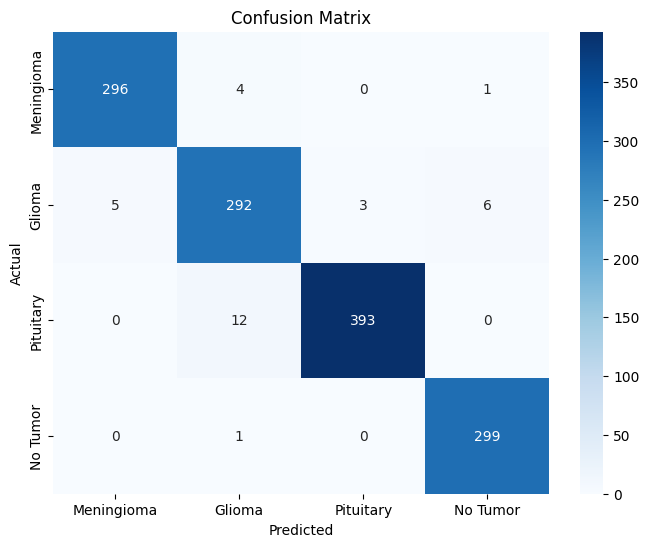

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary", "No Tumor"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Streamlit App

In [ ]:
!pip install streamlit pyngrok

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
app_path = '/content/drive/MyDrive/BrainTumorClsfn/app.py'

In [ ]:
!ngrok authtoken 2tDt0MAABwTQcaQDLDuzAad9gRb_7SpTGNpCX3hiyKx4WvqQf


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pkill -f ngrok

In [ ]:
!streamlit run /content/drive/MyDrive/BrainTumorClsfn/app.py --server.port 8501 --server.address 0.0.0.0 &





  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

  Stopping...


In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print(f"Public URL: {public_url}")


Public URL: NgrokTunnel: "https://05b8-35-240-145-193.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
import os
from pyngrok import ngrok

# Kill any previous running Streamlit instances
!kill -9 $(lsof -t -i:8501)

# Set up ngrok tunnel
ngrok.set_auth_token("2tDt0MAABwTQcaQDLDuzAad9gRb_7SpTGNpCX3hiyKx4WvqQf")
public_url = ngrok.connect("8501")
print(f"Access your Streamlit app here: {public_url}")

# Run Streamlit app in the background
!streamlit run /content/drive/MyDrive/BrainTumorClsfn/app.py --server.port 8501 --server.address 0.0.0.0 &


kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Access your Streamlit app here: NgrokTunnel: "https://8710-35-240-145-193.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
2025-03-24 17:36:55.993 Examining the path of torch.classes raised:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 345, in r